# T0 Unit Example

Here is an example of how to implement and run a T0 unit. This diagram summarizes the whole process:

![](T1_example.png)

## T0 Unit Class

First we need to implement a class that inherits from `AbsAlertFilter`. This class should have at least two methods: the constructor and `apply`. The `apply` method receives an `AmpelAlert` object as a parameter, and it should return one of two values: a string indicating the name of the T2 unit that should process this alert in the next tier in case the alert should be accepted, or `None` in case this alert should be rejected.

For the sake of this example we will implement a simple filter that randomly selects alerts to be processed by the next T2 unit (`SNCOSMO`).

In [1]:
from random import choice
from ampel.base.abstract.AbsAlertFilter import AbsAlertFilter

class RandFilter(AbsAlertFilter):
    version=1.0
    def __init__(self, on_match_t2_units=["SNCOSMO"], base_config=None, run_config=None, logger=None):
        self.on_match_t2_units = on_match_t2_units
    def apply(self, ampel_alert):
        return choice([self.on_match_t2_units, None])

## Input data

Then, we need to provide input data for our T0 unit to run over. In this case, we will simply download a compressed TAR file with alerts from the ZTF survey:

In [3]:
import urllib.request

small_test_tar_url = 'https://ztf.uw.edu/alerts/public/ztf_public_20181129.tar.gz'
small_test_tar_path = 'ztf_public_20181129.tar.gz'

urllib.request.urlretrieve(small_test_tar_url, small_test_tar_path)

('ztf_public_20181129.tar.gz', <http.client.HTTPMessage at 0x7f1088272080>)

# _DevAlertProcessor_ and running the T0 unit

Finally, in order to run our unit in a standalone mode, without the need for the whole AMPEL system to be running, we initialize an object from our T0 unit class and give it as an initialization parameter to a `DevAlertProcessor` object:

In [2]:
from ampel.ztf.pipeline.t0.DevAlertProcessor import DevAlertProcessor

my_filter = RandFilter()
dap = DevAlertProcessor(my_filter, use_dev_alerts=True)

Then, we just proceed to execute the `process_tar` method of the `DevAlertProcessor` object, in order to process the compressed TAR file we downloaded previously. We can measure the execution time with the help of the `time` Python standard library module:

In [4]:
import time

print ("processing alerts from %s" % small_test_tar_path)
start = time.time()
nproc = dap.process_tar(small_test_tar_path, iter_max=200)
end = time.time()
print ("processed %d alerts in %.2e sec"%(nproc, end-start))

processing alerts from ztf_public_20181129.tar.gz
2019-01-18 16:37:02 INFO + Ingesting 697251924815010000 (objectId: ZTF18abvetqi)
2019-01-18 16:37:02 INFO - Rejecting 697252380615010002 (objectId: ZTF18abryrxy)
2019-01-18 16:37:02 INFO + Ingesting 697251920615010004 (objectId: ZTF18abvryvj)
2019-01-18 16:37:02 INFO + Ingesting 697251920415015001 (objectId: ZTF18abvdmcb)
2019-01-18 16:37:02 INFO - Rejecting 697251920815010007 (objectId: ZTF18abvlvih)
2019-01-18 16:37:02 INFO - Rejecting 697251922015015007 (objectId: ZTF18acsbjvl)
2019-01-18 16:37:02 INFO - Rejecting 697252841015015004 (objectId: ZTF18acsbtce)
2019-01-18 16:37:02 INFO + Ingesting 697252842115015000 (objectId: ZTF18acsbtei)
2019-01-18 16:37:02 INFO - Rejecting 697252842615015009 (objectId: ZTF18acsbtfc)
2019-01-18 16:37:02 INFO + Ingesting 697252382215010000 (objectId: ZTF18acsbthc)
2019-01-18 16:37:02 INFO - Rejecting 697252841315015005 (objectId: ZTF18acsbthq)
2019-01-18 16:37:02 INFO + Ingesting 697252381715010004 (ob

2019-01-18 16:37:02 INFO + Ingesting 697252382015015001 (objectId: ZTF18acsbtho)
2019-01-18 16:37:02 INFO - Rejecting 697252381715010006 (objectId: ZTF18acsbtjv)
2019-01-18 16:37:02 INFO - Rejecting 697252381615015002 (objectId: ZTF18abrabqy)
2019-01-18 16:37:02 INFO - Rejecting 697252381115015002 (objectId: ZTF18abscksd)
2019-01-18 16:37:02 INFO - Rejecting 697251923115010004 (objectId: ZTF18abvrzta)
2019-01-18 16:37:02 INFO + Ingesting 697251926015015004 (objectId: ZTF18acsbjnc)
2019-01-18 16:37:02 INFO + Ingesting 697251921415015003 (objectId: ZTF18abvethj)
2019-01-18 16:37:02 INFO + Ingesting 697251920415010000 (objectId: ZTF18acsbjou)
2019-01-18 16:37:02 INFO + Ingesting 697251920815010004 (objectId: ZTF18abvdmfx)
2019-01-18 16:37:02 INFO + Ingesting 697251922515015010 (objectId: ZTF18acgbarm)
2019-01-18 16:37:02 INFO + Ingesting 697252841015015012 (objectId: ZTF18abslhsh)
2019-01-18 16:37:02 INFO - Rejecting 697252842715010000 (objectId: ZTF18absqged)
2019-01-18 16:37:02 INFO - R

After the dataset has been processed, we can see which alerts were accepted and which were rejected with the help of the `get_accepted_alerts` and the `get_rejected_alerts` methods, respectively:

In [5]:
n_good, n_bad = len(dap.get_accepted_alerts()), len(dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

96 alerts accepted by the filter (48.00 perc)
104 alerts rejected by the filter (52.00 perc)


We can also visualize any of these alerts with the help of the `summary_plot` method of the `AmpelAlertPlotter` class. This method receives an `AmpelAlert` object and plots a summary for it. In this case we will plot a random alert from the set of accepted alerts:

In [6]:
from ampel.ztf.view.AmpelAlertPlotter import AmpelAlertPlotter

accepted = dap.get_accepted_alerts()
accepted_plot = AmpelAlertPlotter(interactive=True)

2019-01-18 16:37:03 INFO Initialized AmpelAlertPlotter in interactive mode.


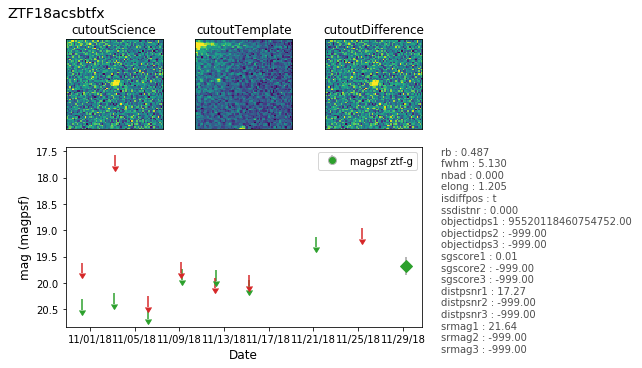

In [7]:
accepted_plot.summary_plot(choice(accepted))

Of course, we can also plot any alert from the set of rejected alerts:

In [8]:
rejected = dap.get_rejected_alerts()
rejected_plot = AmpelAlertPlotter(interactive=True)

2019-01-18 16:37:03 INFO Initialized AmpelAlertPlotter in interactive mode.


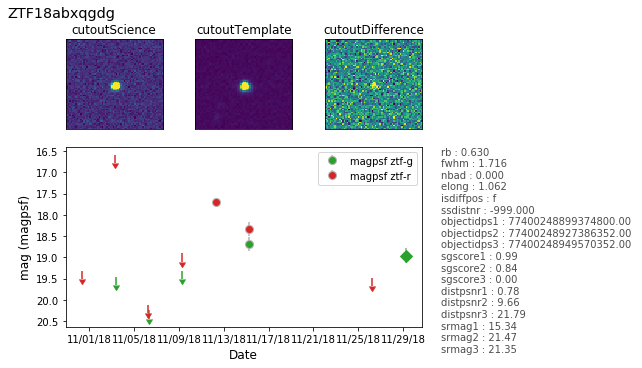

In [9]:
rejected_plot.summary_plot(choice(rejected))

## Re-running _DevAlertProcessor_ on previously accepted alerts

One of the good aspects of the T0 module is that it allows to re-run units over a set of alerts multiple times. In this case, we will run the same random filter we implemented previously, this time only over the set of accepted alerts. Of course, in a real case it is also possible to run a different unit over the processed set of alerts.

In [10]:
new_filter = RandFilter()
recursive_dap = DevAlertProcessor(new_filter)

print ("Reprocessing alerts from %s" % small_test_tar_path)
start = time.time()
recursive_dap.process_loaded_alerts(accepted)
end = time.time()
print ("Reprocessed %d alerts in %.2e sec"%(nproc, end-start))
new_accepted = recursive_dap.get_accepted_alerts()

Reprocessing alerts from ztf_public_20181129.tar.gz
2019-01-18 16:37:04 INFO - Rejecting 697251924815010000 (objectId: ZTF18abvetqi)
2019-01-18 16:37:04 INFO - Rejecting 697251920615010004 (objectId: ZTF18abvryvj)
2019-01-18 16:37:04 INFO + Ingesting 697251920415015001 (objectId: ZTF18abvdmcb)
2019-01-18 16:37:04 INFO + Ingesting 697252842115015000 (objectId: ZTF18acsbtei)
2019-01-18 16:37:04 INFO + Ingesting 697252382215010000 (objectId: ZTF18acsbthc)
2019-01-18 16:37:04 INFO - Rejecting 697252381715010004 (objectId: ZTF18abodprr)
2019-01-18 16:37:04 INFO - Rejecting 697252384915015004 (objectId: ZTF18abomlbr)
2019-01-18 16:37:04 INFO - Rejecting 697252382115010005 (objectId: ZTF18acbxqzh)
2019-01-18 16:37:04 INFO + Ingesting 697252844615015010 (objectId: ZTF18acsbtvy)
2019-01-18 16:37:04 INFO - Rejecting 697252844215015004 (objectId: ZTF18acsbtzj)
2019-01-18 16:37:04 INFO + Ingesting 697252383615015001 (objectId: ZTF18abupgps)
2019-01-18 16:37:04 INFO + Ingesting 697252382815010006 (

Same as before, we can inspect the set of rejected and accepted alerts and plot any alert from these sets:

In [11]:
n_good, n_bad = len(recursive_dap.get_accepted_alerts()), len(recursive_dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

53 alerts accepted by the filter (26.50 perc)
43 alerts rejected by the filter (21.50 perc)


2019-01-18 16:37:04 INFO Initialized AmpelAlertPlotter in interactive mode.


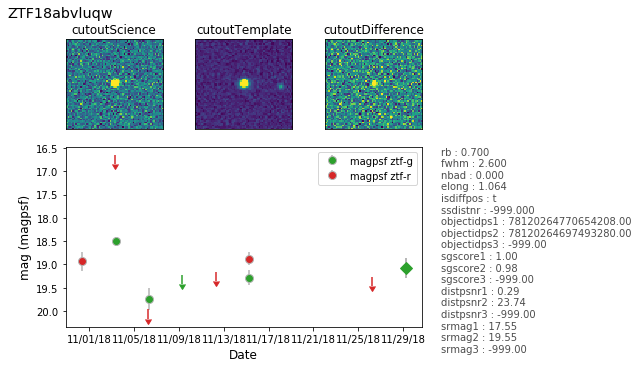

In [12]:
new_accepted_plot = AmpelAlertPlotter(interactive=True)
new_accepted_plot.summary_plot(choice(new_accepted))

Finally, we may remove the compressed TAR file we previously downloaded.

In [13]:
import os
os.remove(small_test_tar_path)